## List of Imports 

In [142]:
from __future__ import print_function, division

In [181]:
import pickle
import itertools 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.learning_curve import learning_curve

from sklearn.model_selection import ShuffleSplit
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


%matplotlib inline 

## Loading Data & More Detailed Analysis

In [144]:
with open('../../Data/cuisine_clean.pickle', 'rb') as f:
    df_cuisine = pickle.load(f)

In [145]:
df_cuisine.head()

,cuisine,id,ingredients,1% low-fat milk,active dry yeast,all purpose unbleached flour,allspice,almond extract,almonds,ancho chile pepper,...,wonton wrappers,worcestershire sauce,yeast,yellow bell pepper,yellow corn meal,yellow onion,yellow squash,yoghurt,yukon gold potatoes,zucchini
0,greek,10259,"romaine lettuce,black olives,grape tomatoes,ga...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,25693,"plain flour,ground pepper,salt,tomatoes,ground...",0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,filipino,20130,"eggs,pepper,salt,mayonaise,cooking oil,green c...",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,indian,22213,"water,vegetable oil,wheat,salt",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,13162,"black pepper,shallots,cornflour,cayenne pepper...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
df_cuisine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 548 entries, cuisine to zucchini
dtypes: int64(546), object(2)
memory usage: 166.3+ MB


In [147]:
df_cuisine.columns

Index(['cuisine', 'id', 'ingredients', '1% low-fat milk', 'active dry yeast',
       'all purpose unbleached flour', 'allspice', 'almond extract', 'almonds',
       'ancho chile pepper',
       ...
       'wonton wrappers', 'worcestershire sauce', 'yeast',
       'yellow bell pepper', 'yellow corn meal', 'yellow onion',
       'yellow squash', 'yoghurt', 'yukon gold potatoes', 'zucchini'],
      dtype='object', length=548)

In [148]:
# checks the use of each ingredient in each cuisine
igt_cuisine = df_cuisine.groupby('cuisine').sum()

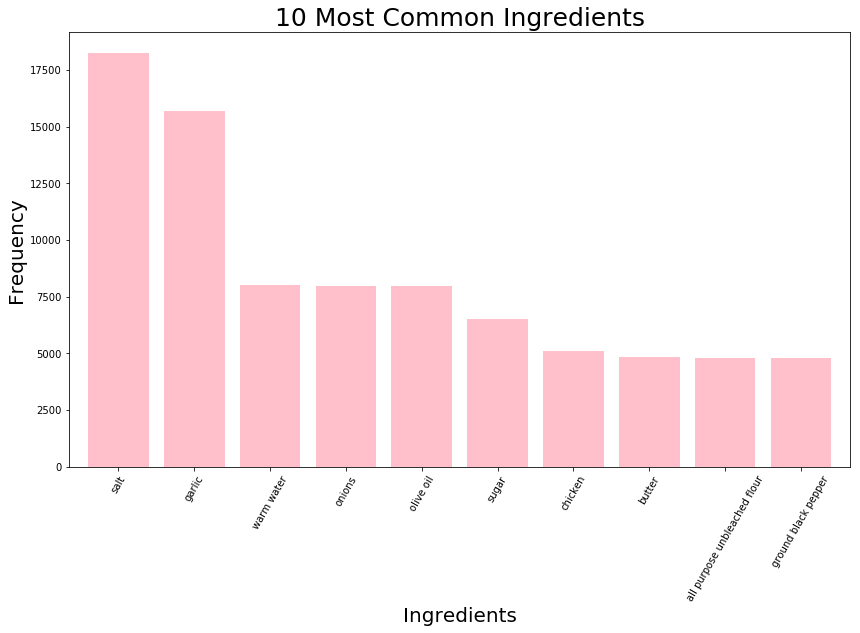

In [149]:
# visualizes
igt_use = igt_cuisine.sum(axis=0).sort_values(ascending=False)
ax = igt_use[1:11].plot(kind='bar',linewidth=10
                        ,width=0.8,align='center'
                        ,figsize =(14,8)
                        ,color='pink',rot = 60)
plt.xlabel('Ingredients', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.title('10 Most Common Ingredients', fontsize=25)

In [150]:
igt_use[1:20]

salt                            18263
garlic                          15710
warm water                       8034
onions                           7972
olive oil                        7971
sugar                            6538
chicken                          5106
butter                           4847
all purpose unbleached flour     4811
ground black pepper              4784
vegetable oil                    4645
pepper                           4438
corn                             3452
eggs                             3388
soy sauce                        3296
lemon                            3186
lime                             3130
kosher salt                      3113
green onions                     3078
dtype: int64

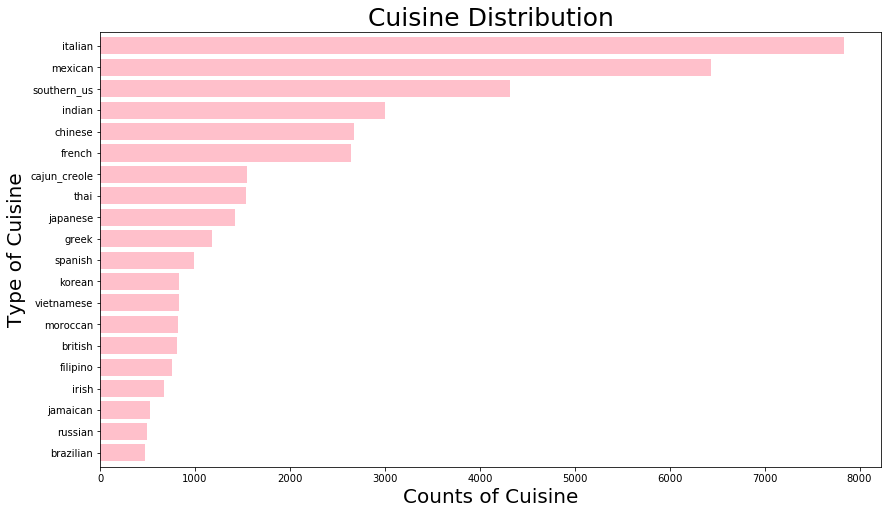

In [151]:
cuisine_counts = df_cuisine['cuisine'].value_counts().sort_values()
cuisine_counts.plot(kind='barh',color = 'pink'
                    ,linewidth=10,width=0.8,align='center',figsize =(14,8))
plt.xlabel('Counts of Cuisine', fontsize=20)
plt.ylabel('Type of Cuisine', fontsize=20)
plt.title('Cuisine Distribution', fontsize=25)

In [152]:
dcf = df_cuisine.groupby('cuisine').sum()

In [153]:
# Find the mostly used ingredients (3) for each cuisine besides common ones, 
# like water, salt or oil
dcf.iloc[0,1:].sort_values(ascending=False)

salt                           196
garlic                         171
onions                         133
lime                           129
olive oil                      118
warm water                      89
coconut                         79
sugar                           69
tomatoes                        63
sweetened condensed milk        57
pepper                          56
eggs                            52
ground black pepper             48
butter                          48
milk                            44
vegetable oil                   43
ice                             43
cilantro                        40
chicken                         37
orange                          36
black beans                     36
red bell pepper                 29
bay leaves                      29
chopped cilantro                27
carrots                         26
lemon                           24
green onions                    23
shrimp                          23
unsalted butter     

## Modeling - Set model performance baseline 
Given the dominance of Italian food in the training set, the first model will predict 'italian' all the time. This is to establish a baseline for model performance and see how much I can improve on performance through employing different models and approaches. 

In [154]:
# number of italian cuisines in the training set 
itl_cn = df_cuisine['cuisine'].value_counts().sort_values(ascending=False)[0]
# % of total number of cuisines in the training set
p_itl = itl_cn/len(df_cuisine['cuisine'])
p_itl

0.19706340825665009

In [155]:
def predict_italian(input_x):
    italian = ['italian']*(len(input_x))
    return italian 

In [156]:
x1 = df_cuisine.iloc[:,3:]
y = df_cuisine['cuisine']

In [157]:
pred_itl = predict_italian(x1)
itl_score = accuracy_score(y, pred_itl)
print("The baseline in terms of model accuracy is: ", itl_score)

The baseline in terms of model accuracy is:  0.197063408257


##### Get rid of the most common ingredients - will not add much value as most cuisines use them 

In [158]:
igt_cuisine.sum(axis=0).sort_values(ascending=False)[1:22]

salt                            18263
garlic                          15710
warm water                       8034
onions                           7972
olive oil                        7971
sugar                            6538
chicken                          5106
butter                           4847
all purpose unbleached flour     4811
ground black pepper              4784
vegetable oil                    4645
pepper                           4438
corn                             3452
eggs                             3388
soy sauce                        3296
lemon                            3186
lime                             3130
kosher salt                      3113
green onions                     3078
tomatoes                         3058
large eggs                       2948
dtype: int64

In [159]:
df = df_cuisine.iloc[:,3:]

In [160]:
def remove_common_ingredients(column):
    if sum(column) >= 2948:
        return None
    else: 
        return column

In [161]:
df = df.apply(remove_common_ingredients, axis=0)

In [162]:
df.head()

,1% low-fat milk,active dry yeast,all purpose unbleached flour,allspice,almond extract,almonds,ancho chile pepper,anchovy fillets,andouille sausage,apple cider vinegar,...,wonton wrappers,worcestershire sauce,yeast,yellow bell pepper,yellow corn meal,yellow onion,yellow squash,yoghurt,yukon gold potatoes,zucchini
0,0,0,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,None,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,None,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
# check to make sure only common ingredients are set to NaN 
sum(df['active dry yeast'])

377

In [164]:
df.dropna(axis=1,how='all',inplace=True)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Columns: 524 entries, 1% low-fat milk to zucchini
dtypes: int64(524)
memory usage: 159.0 MB


## Modeling - Try different classification estimators 
 * Logistic Regression
 * LinearSVC  
 * Bernoull Naive Bayes 
 * Decision Tree
 * Random Forest 

### Train-Test Split - hold 30% as holdout set for testing 

In [166]:
X = df
y = df_cuisine['cuisine']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=7777)

In [168]:
print('The dimensinality of training features: ', X_train.shape)
print('The dimensinality of training target: ', y_train.shape)
print('The dimensinality of testing features: ', X_test.shape)
print('The dimensinality of testing target: ', y_test.shape)

The dimensinality of training features:  (27841, 524)
The dimensinality of training target:  (27841,)
The dimensinality of testing features:  (11933, 524)
The dimensinality of testing target:  (11933,)


In [169]:
df_test = pd.concat([X_test, y_test], axis=1)

## Building pipelines for modeling

#### 1). Model w/ parameter tuning not using GridSearchCV (manually instead)

In [170]:
# GridSearch takes a long time to run for this dataset, so the 
# below function can be utilized to speed up the training process. 

def modeling(estimator, X_train, y_train, X_test, y_test):
    """ This function trains a model and returns the test score. """
    estimator = estimator.fit(X_train, y_train)
    pred_tr = estimator.predict(X_train)
    pred_tt = estimator.predict(X_test)
    score_tr = accuracy_score(y_train, pred_tr)
    score_tt = accuracy_score(y_test, pred_tt)
    score_f1 = f1_score(y_test, pred_tt,average='macro')
    score_precision = precision_score(y_test, pred_tt,average="macro")
    score_recall = recall_score(y_test, pred_tt,average="macro")
    
    print('|Accuracy on Training|: ', score_tr
          ,'\n','|Accuracy on Testing|: ', score_tt,'\n'
          ,'|F1 Score|: ', score_f1)
    
    return pred_tt, estimator, score_tt, score_f1

#### 2). Model w/ parameter tuning using GridSearchCV 
#### Initiate cross-validation iterator

In [171]:
cv = ShuffleSplit(X_train.shape[0], random_state=7777)

#### Tune the hyperparameters and build model 

In [172]:
# def model_initiation(estimator, X, y, cv, param_grid):
#     """ This function returns the best estimator by using 
#     GridSearchCV to test on 
#     different combinations of parameters. """
#     classifier = GridSearchCV(estimator, param_grid
#     , cv=cv, scoring='accuracy')
#     classifier.fit(X,y)
    
#     best_estimator = classifier.best_estimator_
#     best_score = classifier.best_score_
#     best_params = classifier.best_params_
    
#     print('|Best Model|: ----------', best_estimator
#           ,'\n','|Highest Accuracy on Training|: ----------'
#     , best_score_lr)
    
#     return best_estimator 

#### Debug algorithm with learning curve 
X_train is randomly split into a training and a test set 10 times (n_iter=10). Each point on the training-score curve is the average of 10 scores where the model was trained and evaluated on the first i training examples. Each point on the cross-validation score curve is the average of 10 scores where the model was trained on the first i training examples and evaluated on all examples of the test set.

In [173]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """ This function plots the learning curve. """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std
                     , alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### Evaluate on the test set

In [174]:
# def model_prediction(best_estimator, x, y):
#     prediction = best_estimator.predict(x)
#     test_score = accuracy_score(y, prediction)
#     # test_score = classifier.score(X_test, y_test)
    
#     print('|Accuracy on Testing|: ', test_score)
    
#     return test_score,prediction 

#### Cross validation scores 

In [175]:
def cross_val_scores(best_model,x,y):
    score = cross_val_score(best_model, x, y, cv=10)
    return score

#### Plot confusion matrix 

In [206]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdGy):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Classification Estimator 1: Logistic Regression

In [25]:
# Initiates parameters:  
# Uses grid search to find out the best C value.
# Basically smaller C specify stronger regularization.

# parameters_lr = {'C': [0.01, 0.1, 1, 10] }  

# Initiates estimator: 
estimator_lr = LogisticRegression()

In [26]:
# W/ GridSearchCV parameter-tuning 

# best_lr = model_initiation(estimator_lr, X_train, y_train
#                            , cv=cv, param_grid=parameters_lr)

# best_lr

In [109]:
# W/o GridSearchCV parameter-tuning 
result_lr = modeling(estimator_lr, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.742502065299 
 |Accuracy on Testing|:  0.707366127545 
 |F1 Score|:  0.593504763741


<module 'matplotlib.pyplot' from '/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

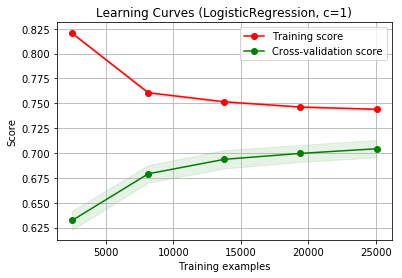

In [31]:
model_lr = result_lr[1]
title_lr = 'Learning Curves (LogisticRegression, c=1)' 
plot_learning_curve(model_lr, title_lr, X_train, y_train, cv=10)

In [110]:
# result_lr = model_prediction(best_lr, X_test, y_test)

In [32]:
df_test['predicted_lr'] = result_lr[0]
df_test[['predicted_lr','cuisine']].head(10)

In [63]:
cv_score = cross_val_scores(model_lr, X, y)

In [64]:
print("Accuracy: %0.2f (+/- %0.2f)" 
      % (cv_score.mean(), cv_score.std() * 2))

Accuracy: 0.71 (+/- 0.01)


In [123]:
print(classification_report(y_test, result_lr[0]))

              precision    recall  f1-score   support

   brazilian       0.48      0.21      0.30       135
     british       0.40      0.19      0.26       221
cajun_creole       0.76      0.66      0.70       486
     chinese       0.72      0.80      0.76       778
    filipino       0.69      0.48      0.56       233
      french       0.51      0.54      0.52       774
       greek       0.78      0.58      0.67       354
      indian       0.82      0.85      0.84       876
       irish       0.50      0.29      0.37       190
     italian       0.69      0.87      0.77      2352
    jamaican       0.78      0.50      0.61       154
    japanese       0.73      0.54      0.62       459
      korean       0.77      0.57      0.66       257
     mexican       0.82      0.89      0.85      1929
    moroccan       0.79      0.62      0.69       243
     russian       0.61      0.28      0.38       156
 southern_us       0.62      0.70      0.66      1346
     spanish       0.51    

### Classification Estimator: Linear Support Vector Classification
* Same process applies:
    1. Choose estimator
    2. Choose cross-validation iterator
    3. Tune the hyperparameters
    4. Debug algorithm with learning curve
    5. Evaluate on the test set

In [128]:
# Initiates estimator: 
estimator_svc = LinearSVC(random_state=7777,penalty='l2')

In [129]:
result_svc = modeling(estimator_svc, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.749865306562 
 |Accuracy on Testing|:  0.704014078606 
 |F1 Score|:  0.587896376818


In [37]:
# W/ GridSearchCV 

# best_svc = model_initiation(estimator_svc
#, X_train, y_train, cv=cv, param_grid=parameters_svc)

# best_svc

<module 'matplotlib.pyplot' from '/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

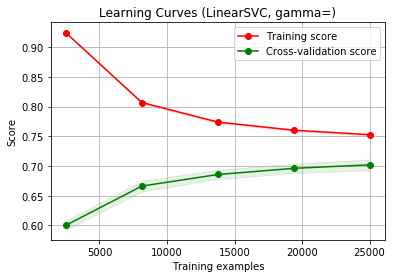

In [41]:
model_svc = result_svc[1]
title_svc = 'Learning Curves (LinearSVC)' 
plot_learning_curve(model_svc, title_svc, X_train, y_train, cv=10)

In [ ]:
# result_svc = model_prediction(best_svc, X_test, y_test)

In [42]:
df_test['predicted_svc'] = result_svc[0]
df_test[['predicted_svc','cuisine'
         ,'predicted_lr']].head(10)

In [66]:
svc_cv_score = cross_val_scores(model_svc, X, y)

In [67]:
print("Accuracy: %0.2f (+/- %0.2f)" 
      % (svc_cv_score.mean(), svc_cv_score.std() * 2))

Accuracy: 0.71 (+/- 0.01)


In [122]:
print(classification_report(y_test, result_svc[0]))

              precision    recall  f1-score   support

   brazilian       0.41      0.25      0.31       135
     british       0.34      0.18      0.23       221
cajun_creole       0.75      0.67      0.71       486
     chinese       0.72      0.78      0.75       778
    filipino       0.59      0.51      0.55       233
      french       0.50      0.54      0.52       774
       greek       0.74      0.62      0.67       354
      indian       0.82      0.84      0.83       876
       irish       0.41      0.28      0.33       190
     italian       0.71      0.86      0.78      2352
    jamaican       0.67      0.52      0.59       154
    japanese       0.73      0.54      0.62       459
      korean       0.70      0.61      0.65       257
     mexican       0.83      0.88      0.86      1929
    moroccan       0.75      0.66      0.70       243
     russian       0.52      0.28      0.37       156
 southern_us       0.64      0.68      0.66      1346
     spanish       0.55    

### Classification Estimator: Random Forest
* Same process applies:
    1. Choose estimator
    2. Choose cross-validation iterator
    3. Tune the hyperparameters
    4. Debug algorithm with learning curve
    5. Evaluate on the test set
    6. Test over-fitting in model selection 

In [112]:
estimator_rf = RandomForestClassifier(random_state=7777)
result_rf = modeling(estimator_rf, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.957293200675 
 |Accuracy on Testing|:  0.637392105925 
 |F1 Score|:  0.507803169621


<module 'matplotlib.pyplot' from '/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

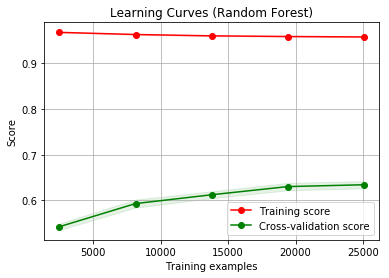

In [69]:
model_rf = result_rf[1]
title_rf = 'Learning Curves (Random Forest)' 
plot_learning_curve(model_rf, title_rf, X_train, y_train, cv=10)

In [70]:
df_test['predicted_rf'] = result_rf[0]
df_test[['predicted_svc','cuisine'
         ,'predicted_lr', 'predicted_rf']].head(10)

,predicted_cuisine_svc,cuisine,predicted_cuisine_lr,predicted_cuisine_rf
26745,cajun_creole,cajun_creole,cajun_creole,cajun_creole
2842,mexican,mexican,mexican,mexican
36766,thai,spanish,thai,indian
19107,moroccan,moroccan,mexican,indian
38651,southern_us,japanese,southern_us,russian
11251,italian,italian,italian,italian
8109,cajun_creole,korean,italian,thai
20919,irish,british,irish,southern_us
2472,southern_us,southern_us,southern_us,southern_us
36048,italian,mexican,italian,italian


In [71]:
rf_cv_score = cross_val_scores(model_rf, X, y)
print("Accuracy: %0.2f (+/- %0.2f)" 
      % (rf_cv_score.mean(), rf_cv_score.std() * 2))

Accuracy: 0.65 (+/- 0.01)


In [121]:
print(classification_report(y_test, result_rf[0]))

              precision    recall  f1-score   support

   brazilian       0.33      0.32      0.32       135
     british       0.27      0.23      0.25       221
cajun_creole       0.67      0.57      0.62       486
     chinese       0.65      0.73      0.68       778
    filipino       0.45      0.42      0.44       233
      french       0.40      0.46      0.43       774
       greek       0.65      0.53      0.58       354
      indian       0.71      0.82      0.76       876
       irish       0.30      0.24      0.27       190
     italian       0.69      0.80      0.74      2352
    jamaican       0.61      0.34      0.44       154
    japanese       0.59      0.52      0.55       459
      korean       0.60      0.52      0.56       257
     mexican       0.78      0.85      0.81      1929
    moroccan       0.59      0.40      0.48       243
     russian       0.47      0.28      0.35       156
 southern_us       0.61      0.58      0.59      1346
     spanish       0.43    

### Classification Estimator: Bernoulli Naive Bayes

In [113]:
estimator_nb = BernoulliNB(alpha=1)
result_nb = modeling(estimator_nb, X_train, y_train, X_test, y_test)

|Accuracy on Training|:  0.70270464423 
 |Accuracy on Testing|:  0.676275873628 
 |F1 Score|:  0.562160200417


<module 'matplotlib.pyplot' from '/Users/liyuqiao/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

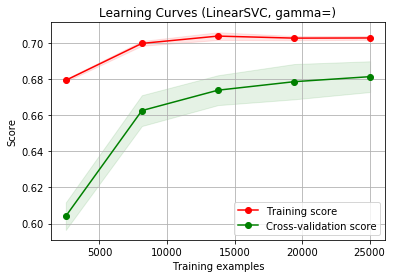

In [85]:
model_nb = result_nb[1]
title_nb = 'Learning Curves (Bernoulli Naive Bayes)' 
plot_learning_curve(model_nb, title_svc, X_train, y_train, cv=10)

In [87]:
df_test['predicted_nb'] = result_nb[0]
df_test[['predicted_svc','cuisine','predicted_nb'
         ,'predicted_lr', 'predicted_rf']].head(10)

,predicted_cuisine_svc,cuisine,predicted_cuisine_nb,predicted_cuisine_lr,predicted_cuisine_rf
26745,cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole
2842,mexican,mexican,mexican,mexican,mexican
36766,thai,spanish,mexican,thai,indian
19107,moroccan,moroccan,moroccan,mexican,indian
38651,southern_us,japanese,cajun_creole,southern_us,russian
11251,italian,italian,italian,italian,italian
8109,cajun_creole,korean,chinese,italian,thai
20919,irish,british,british,irish,southern_us
2472,southern_us,southern_us,french,southern_us,southern_us
36048,italian,mexican,italian,italian,italian


In [88]:
nb_cv_score = cross_val_scores(model_nb, X, y)
print("Accuracy: %0.2f (+/- %0.2f)" 
      % (nb_cv_score.mean(), nb_cv_score.std() * 2))

Accuracy: 0.68 (+/- 0.01)


In [120]:
# classification report
print(classification_report(y_test, result_nb[0]))

              precision    recall  f1-score   support

   brazilian       0.34      0.14      0.20       135
     british       0.22      0.25      0.24       221
cajun_creole       0.62      0.66      0.64       486
     chinese       0.75      0.78      0.77       778
    filipino       0.55      0.52      0.53       233
      french       0.45      0.53      0.49       774
       greek       0.68      0.56      0.62       354
      indian       0.84      0.79      0.82       876
       irish       0.47      0.28      0.35       190
     italian       0.75      0.80      0.78      2352
    jamaican       0.66      0.47      0.55       154
    japanese       0.65      0.54      0.59       459
      korean       0.73      0.59      0.65       257
     mexican       0.87      0.85      0.86      1929
    moroccan       0.69      0.64      0.66       243
     russian       0.53      0.22      0.31       156
 southern_us       0.51      0.66      0.57      1346
     spanish       0.50    

## Model Performance Summary

In [135]:
model_results = pd.DataFrame(
    {'Estimator': ['Logistic Regression','LinearSVC'
                   ,'Random Forest','Bernoulli Naive Bayes'],
     'Accuracy': [result_lr[2], result_svc[2], result_rf[2], result_nb[2]],
     'F1': [result_lr[3],result_svc[3],result_rf[3],result_nb[3]]
    })

In [136]:
model_results

,Accuracy,Estimator,F1
0,0.707366,Logistic Regression,0.593505
1,0.704014,LinearSVC,0.587896
2,0.637392,Random Forest,0.507803
3,0.676276,Bernoulli Naive Bayes,0.562160


Confusion matrix, without normalization
[[  29    0    6    1    3    6    0    2    0   30    0    0    0   22
     0    1   24    5    6    0]
 [   2   43    2    1    4   43    2    4   13   33    4    1    0    8
     0    1   56    3    1    0]
 [   2    3  321    3    1   17    1    0    0   37    0    0    0   14
     1    3   78    5    0    0]
 [   3    1    2  621    7    4    1    4    0   22    1   38   18   14
     2    0   21    1   14    4]
 [   2    0    4   18  111    6    0    6    6   21    0    4    3   13
     0    2   20    3    6    8]
 [   1    6    6    4    1  419    7    6   14  200    5    2    0   17
     1    7   68   10    0    0]
 [   0    1    0    0    1   22  206    6    1   80    0    1    0   12
     5    0   11    8    0    0]
 [   2    2    0    9    3    3    2  748    0   16    3   10    1   33
    16    0   11    3   13    1]
 [   0   18    0    0    1   26    0    3   55   21    2    0    1    8
     1    2   48    4    0    0]
 [   1    7   1

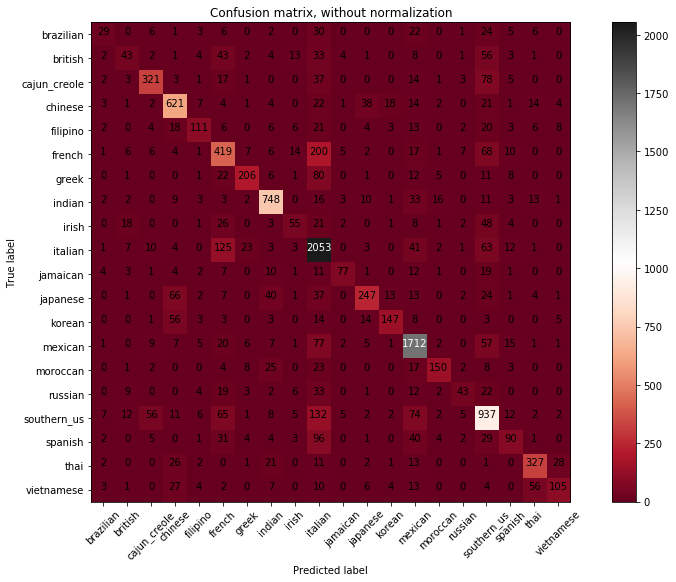

In [207]:
class_names = igt_cuisine.index

# Compute confusion matrix
cnf_matrix_lr = confusion_matrix(y_test, result_lr[0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.figure(figsize=(12,8))
plot_confusion_matrix(cnf_matrix_lr, classes=class_names
                      ,title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True
#                       ,title='Normalized confusion matrix')